# Predicting Insurance Charges

![](image.jpg)

## Dataset Summary
`insurance.csv` is the dataset that we will be using to train our model, while `validation_data.csv` will be the 'unseen' dataset to test our model accuracy.

The given description of the data is as follows:

| Column    | Data Type | Description                                                      |
|-----------|-----------|------------------------------------------------------------------|
| `age`       | int       | Age of the primary beneficiary.                                  |
| `sex`       | object    | Gender of the insurance contractor (male or female).             |
| `bmi`       | float     | Body mass index, a key indicator of body fat based on height and weight. |
| `children`  | int       | Number of dependents covered by the insurance plan.              |
| `smoker`    | object    | Indicates whether the beneficiary smokes (yes or no).            |
| `region`    | object    | The beneficiary's residential area in the US, divided into four regions. |
| `charges`   | float     | Individual medical costs billed by health insurance.             |


From the summary statistics the data will need to be cleaned for:
- missing values (66 count out of total)
- inconsistent input of the same values (eg. "male", "man", "M" is referring to the same gender)
- integer values stored as string (eg. charges containing $-symbol is stored as string).
- unexpected negative values in `age` and `children` column.

In [15]:
# Re-run this cell
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Loading the insurance dataset
insurance_data_path = 'insurance.csv'
validation_data_path = 'validation_dataset.csv'
insurance = pd.read_csv(insurance_data_path)
validation = pd.read_csv(validation_data_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


In [16]:
# Summary of the data
summary = insurance.describe(include='all')

# Checking for missing values
missing_values = insurance.isnull().sum()

# Checking for unique values in categorical columns
unique_values = {col: insurance[col].unique() for col in insurance.select_dtypes(include=['object']).columns}

summary, missing_values, unique_values

(                age   sex          bmi     children smoker     region charges
 count   1272.000000  1272  1272.000000  1272.000000   1272       1272    1284
 unique          NaN     6          NaN          NaN      2          8    1272
 top             NaN  male          NaN          NaN     no  Southeast    $nan
 freq            NaN   517          NaN          NaN   1013        172      12
 mean      35.214623   NaN    30.560550     0.948899    NaN        NaN     NaN
 std       22.478251   NaN     6.095573     1.303532    NaN        NaN     NaN
 min      -64.000000   NaN    15.960000    -4.000000    NaN        NaN     NaN
 25%       24.750000   NaN    26.180000     0.000000    NaN        NaN     NaN
 50%       38.000000   NaN    30.210000     1.000000    NaN        NaN     NaN
 75%       51.000000   NaN    34.485000     2.000000    NaN        NaN     NaN
 max       64.000000   NaN    53.130000     5.000000    NaN        NaN     NaN,
 age         66
 sex         66
 bmi         66
 ch

## Data Cleaning

Correction will be made to the existing data first before handling missing values, as we might want to use them as a measure to input the missing values (eg. using mean value). The following correction is made:

1. Inconsistent input 
    - `sex`: 'man' and 'M' is replaced with 'male'; while 'woman' and 'F' is replaced with 'female'
    - `region`: inconsistenc capitalisation of letter. Make all value small-cap.
    - `charges`: remove dollar ('$') signs/ convert them into numerical value.
    
2. Unexpected negative value:
    - `age`: transform all negative age into positive integer by applying the factor -1
    - `children`: transform all negative children count into positive integer by applying the factor -1

In [17]:
# Make a copy of the data
insurance_cleaned = insurance.copy()

# Transform negative age by applying -1 factor
insurance_cleaned['age'] = insurance_cleaned['age'].apply(lambda x: -x if x < 0 else x)

# Replace 'M' and 'man' with 'male'; 'F' and 'woman' with 'female'
insurance_cleaned['sex'] = insurance_cleaned['sex'].replace({'M': 'male', 'man': 'male', 'F': 'female', 'woman': 'female'})

# Replace any capital letters in region with small cap
insurance_cleaned['region'] = insurance_cleaned['region'].str.lower()

# Transform negative children value by applying -1 factor
insurance_cleaned['children'] = insurance_cleaned['children'].apply(lambda x: -x if x < 0 else x)

# Convert 'charges' column into numerical by removing the '$' sign
insurance_cleaned['charges'] = insurance_cleaned['charges'].replace(r'[\$,]', '', regex=True).astype(float)

In [18]:
# Summary statistics
summary_stats = insurance_cleaned.describe()

# Count of missing rows
missing_row_count = insurance_cleaned.isnull().sum()

# Percentage of missing data vs overall data
missing_percentage = (missing_row_count / len(insurance_cleaned)) * 100

# Unique values in each column
unique_values = {col: insurance_cleaned[col].unique() for col in insurance_cleaned.select_dtypes(include=['object']).columns}

summary_stats, missing_row_count, missing_percentage, unique_values

(               age          bmi     children       charges
 count  1272.000000  1272.000000  1272.000000   1272.000000
 mean     39.335692    30.560550     1.079403  13286.594477
 std      14.064247     6.095573     1.197618  12142.505233
 min      18.000000    15.960000     0.000000   1121.873900
 25%      27.000000    26.180000     0.000000   4733.582163
 50%      39.000000    30.210000     1.000000   9382.033000
 75%      51.000000    34.485000     2.000000  16579.959053
 max      64.000000    53.130000     5.000000  63770.428010,
 age         66
 sex         66
 bmi         66
 children    66
 smoker      66
 region      66
 charges     66
 dtype: int64,
 age         4.932735
 sex         4.932735
 bmi         4.932735
 children    4.932735
 smoker      4.932735
 region      4.932735
 charges     4.932735
 dtype: float64,
 {'sex': array(['female', 'male', nan], dtype=object),
  'smoker': array(['yes', 'no', nan], dtype=object),
  'region': array(['southwest', 'southeast', 'northwe

Re-running summary statistics and filtering the unique value for categorical column - we can see that all the input are consistent and within reasonable range. We can now proceed with handling missing values.

We propose to handle the missing values as follows:
- `age`: use mean value
- `sex`: use most frequent value
- `children`: use 0 (most frequent value)
- `smoker`: use most frequent value
- `region`: randomly input based on existing data, while maintaining the distribution

Once the missing value for `age`, `sex`, `children`, `somker` and `region` is populated, we will group the data based on these profile and use the average to populate the missing `bmi` and `charges`.

In [19]:
# Filter the insurance_cleaned data to include only rows with missing values
insurance_missing = insurance_cleaned[insurance_cleaned.isnull().any(axis=1)]

# Summary statistics
summary_stats_missing = insurance_missing.describe()

# Count of missing rows
missing_row_count_missing = insurance_missing.isnull().sum()

# Unique values in each column
unique_values_missing = {col: insurance_missing[col].unique() for col in insurance_missing.select_dtypes(include=['object']).columns}

summary_stats_missing, missing_row_count_missing, unique_values_missing

(             age        bmi   children       charges
 count  65.000000  65.000000  65.000000     65.000000
 mean   41.276923  30.308077   1.153846  12828.315705
 std    13.820849   5.660259   1.093029  12347.844705
 min    18.000000  17.290000   0.000000   1131.506600
 25%    30.000000  26.125000   0.000000   4463.205100
 50%    43.000000  30.140000   1.000000   7731.427100
 75%    53.000000  33.250000   2.000000  15230.324050
 max    64.000000  46.530000   3.000000  46151.124500,
 age         66
 sex         66
 bmi         66
 children    66
 smoker      66
 region      66
 charges     66
 dtype: int64,
 {'sex': array(['female', nan, 'male'], dtype=object),
  'smoker': array(['yes', nan, 'no'], dtype=object),
  'region': array([nan, 'southwest', 'southeast', 'northwest', 'northeast'],
        dtype=object)})

In [20]:
# Replace missing age values with the average age (rounded to nearest integer)
average_age = round(insurance_cleaned['age'].mean())
insurance_cleaned['age'].fillna(average_age, inplace=True)

# Replace missing sex values with the most frequent value
most_frequent_sex = insurance_cleaned['sex'].mode()[0]
insurance_cleaned['sex'].fillna(most_frequent_sex, inplace=True)

# Replace missing children values with 0
insurance_cleaned['children'].fillna(0, inplace=True)

# Replace missing smoker values with the most frequent value
most_frequent_smoker = insurance_cleaned['smoker'].mode()[0]
insurance_cleaned['smoker'].fillna(most_frequent_smoker, inplace=True)

C:\Users\ibrah\AppData\Local\Temp\ipykernel_25784\55657822.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  insurance_cleaned['age'].fillna(average_age, inplace=True)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_25784\55657822.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [21]:
import numpy as np

# Calculate the distribution of the 'region' column
region_distribution = insurance_cleaned['region'].value_counts(normalize=True)

# Function to fill missing 'region' values based on the distribution
def fill_missing_region(row, region_distribution):
    if pd.isnull(row['region']):
        row['region'] = np.random.choice(region_distribution.index, p=region_distribution.values)
    return row

# Apply the function to fill missing 'region' values
insurance_cleaned = insurance_cleaned.apply(lambda row: fill_missing_region(row, region_distribution), axis=1)

In [22]:
# Filter rows with missing values in any column
rows_with_missing_values = insurance_cleaned[insurance_cleaned.isnull().any(axis=1)]

# Identify the columns with missing values for each row
missing_row_count = insurance_cleaned.isnull().sum()

missing_row_count

age          0
sex          0
bmi         66
children     0
smoker       0
region       0
charges     66
dtype: int64

We populate the missing value for `bmi` and `charges` using the average calculated based on their `age`-`sex`-`children`-`smoker`-`region` profile. 

We group the age profile based on 10-years interval (to avoid having too many unique age grouping).


In [23]:
import pandas as pd

# Create age groups based on 10-year intervals
insurance_cleaned['age_group'] = pd.cut(insurance_cleaned['age'], bins=range(0, 101, 10), right=False)

# Convert the age_group intervals to strings for JSON serialization
insurance_cleaned['age_group'] = insurance_cleaned['age_group'].astype(str)

# Group by age_group, sex, children, smoker status, and region, then compute the average bmi, average charges, and count
grouped_data = insurance_cleaned.groupby(['age_group', 'sex', 'children', 'smoker', 'region']).agg({
    'bmi': 'mean',
    'charges': 'mean',
    'age_group': 'count'  # Using 'age_group' to count the number of entries in each group
}).rename(columns={'age_group': 'count'}).reset_index()

# Display the grouped data with average bmi, average charges, and count
grouped_data.head()

,age_group,sex,children,smoker,region,bmi,charges,count
0,"[10, 20)",female,0.0,no,northeast,31.706250,4227.596881,12
1,"[10, 20)",female,0.0,no,northwest,34.352000,2133.792280,5
2,"[10, 20)",female,0.0,no,southeast,34.558333,3489.826933,12
3,"[10, 20)",female,0.0,no,southwest,26.414286,1739.758857,7
4,"[10, 20)",female,0.0,yes,northeast,21.660000,14283.459400,1


In [24]:
# Function to fill missing values based on the average of the group
def fill_missing_values(row, grouped_data):
    if pd.isnull(row['bmi']) or pd.isnull(row['charges']):
        group = grouped_data[
            (grouped_data['age_group'] == row['age_group']) &
            (grouped_data['sex'] == row['sex']) &
            (grouped_data['children'] == row['children']) &
            (grouped_data['smoker'] == row['smoker'])
        ]
        if not group.empty:
            if pd.isnull(row['bmi']):
                row['bmi'] = group['bmi'].values[0]
            if pd.isnull(row['charges']):
                row['charges'] = group['charges'].values[0]
    return row

# Apply the function to fill missing values
insurance_cleaned = insurance_cleaned.apply(lambda row: fill_missing_values(row, grouped_data), axis=1)

# Drop the 'age_group' column once missing value is inputed
insurance_cleaned.drop('age_group', axis=1, inplace=True)

In [25]:
# Calculate summary statistics for the insurance_cleaned dataframe
summary_stats = insurance_cleaned.describe()

# Check for missing values in the insurance_cleaned dataframe
missing_values = insurance_cleaned.isnull().sum()

# Display the summary statistics and missing values
summary_stats, missing_values

(               age          bmi     children       charges
 count  1338.000000  1338.000000  1338.000000   1338.000000
 mean     39.319133    30.527500     1.026158  13135.802750
 std      13.712911     5.993270     1.190867  12004.836662
 min      18.000000    15.960000     0.000000   1121.873900
 25%      27.000000    26.148333     0.000000   4828.586213
 50%      39.000000    30.210000     1.000000   9237.375800
 75%      51.000000    34.210000     2.000000  15766.537613
 max      64.000000    53.130000     5.000000  63770.428010,
 age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 charges     0
 dtype: int64)

## Data Transformation on Categorical Data
We perform one-hot encoding for categorical data such as sex and region.

In [26]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Perform one-hot encoding on 'sex', 'region', and 'smoker' columns
encoded_features = encoder.fit_transform(insurance_cleaned[['sex', 'region', 'smoker']])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['sex', 'region', 'smoker']))

# Concatenate the original dataframe with the encoded features
insurance_cleaned = pd.concat([insurance_cleaned, encoded_df], axis=1)

# Drop the original 'sex', 'region', and 'smoker' columns
insurance_cleaned.drop(['sex', 'region', 'smoker'], axis=1, inplace=True)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

## Visualisation for Initial insights
Based on the pair plot for `charges`, we might expect some positive linear relationship between `charges` and `age`; and also `charges` and `bmi` (though this is much more scrattered for `bmi`).

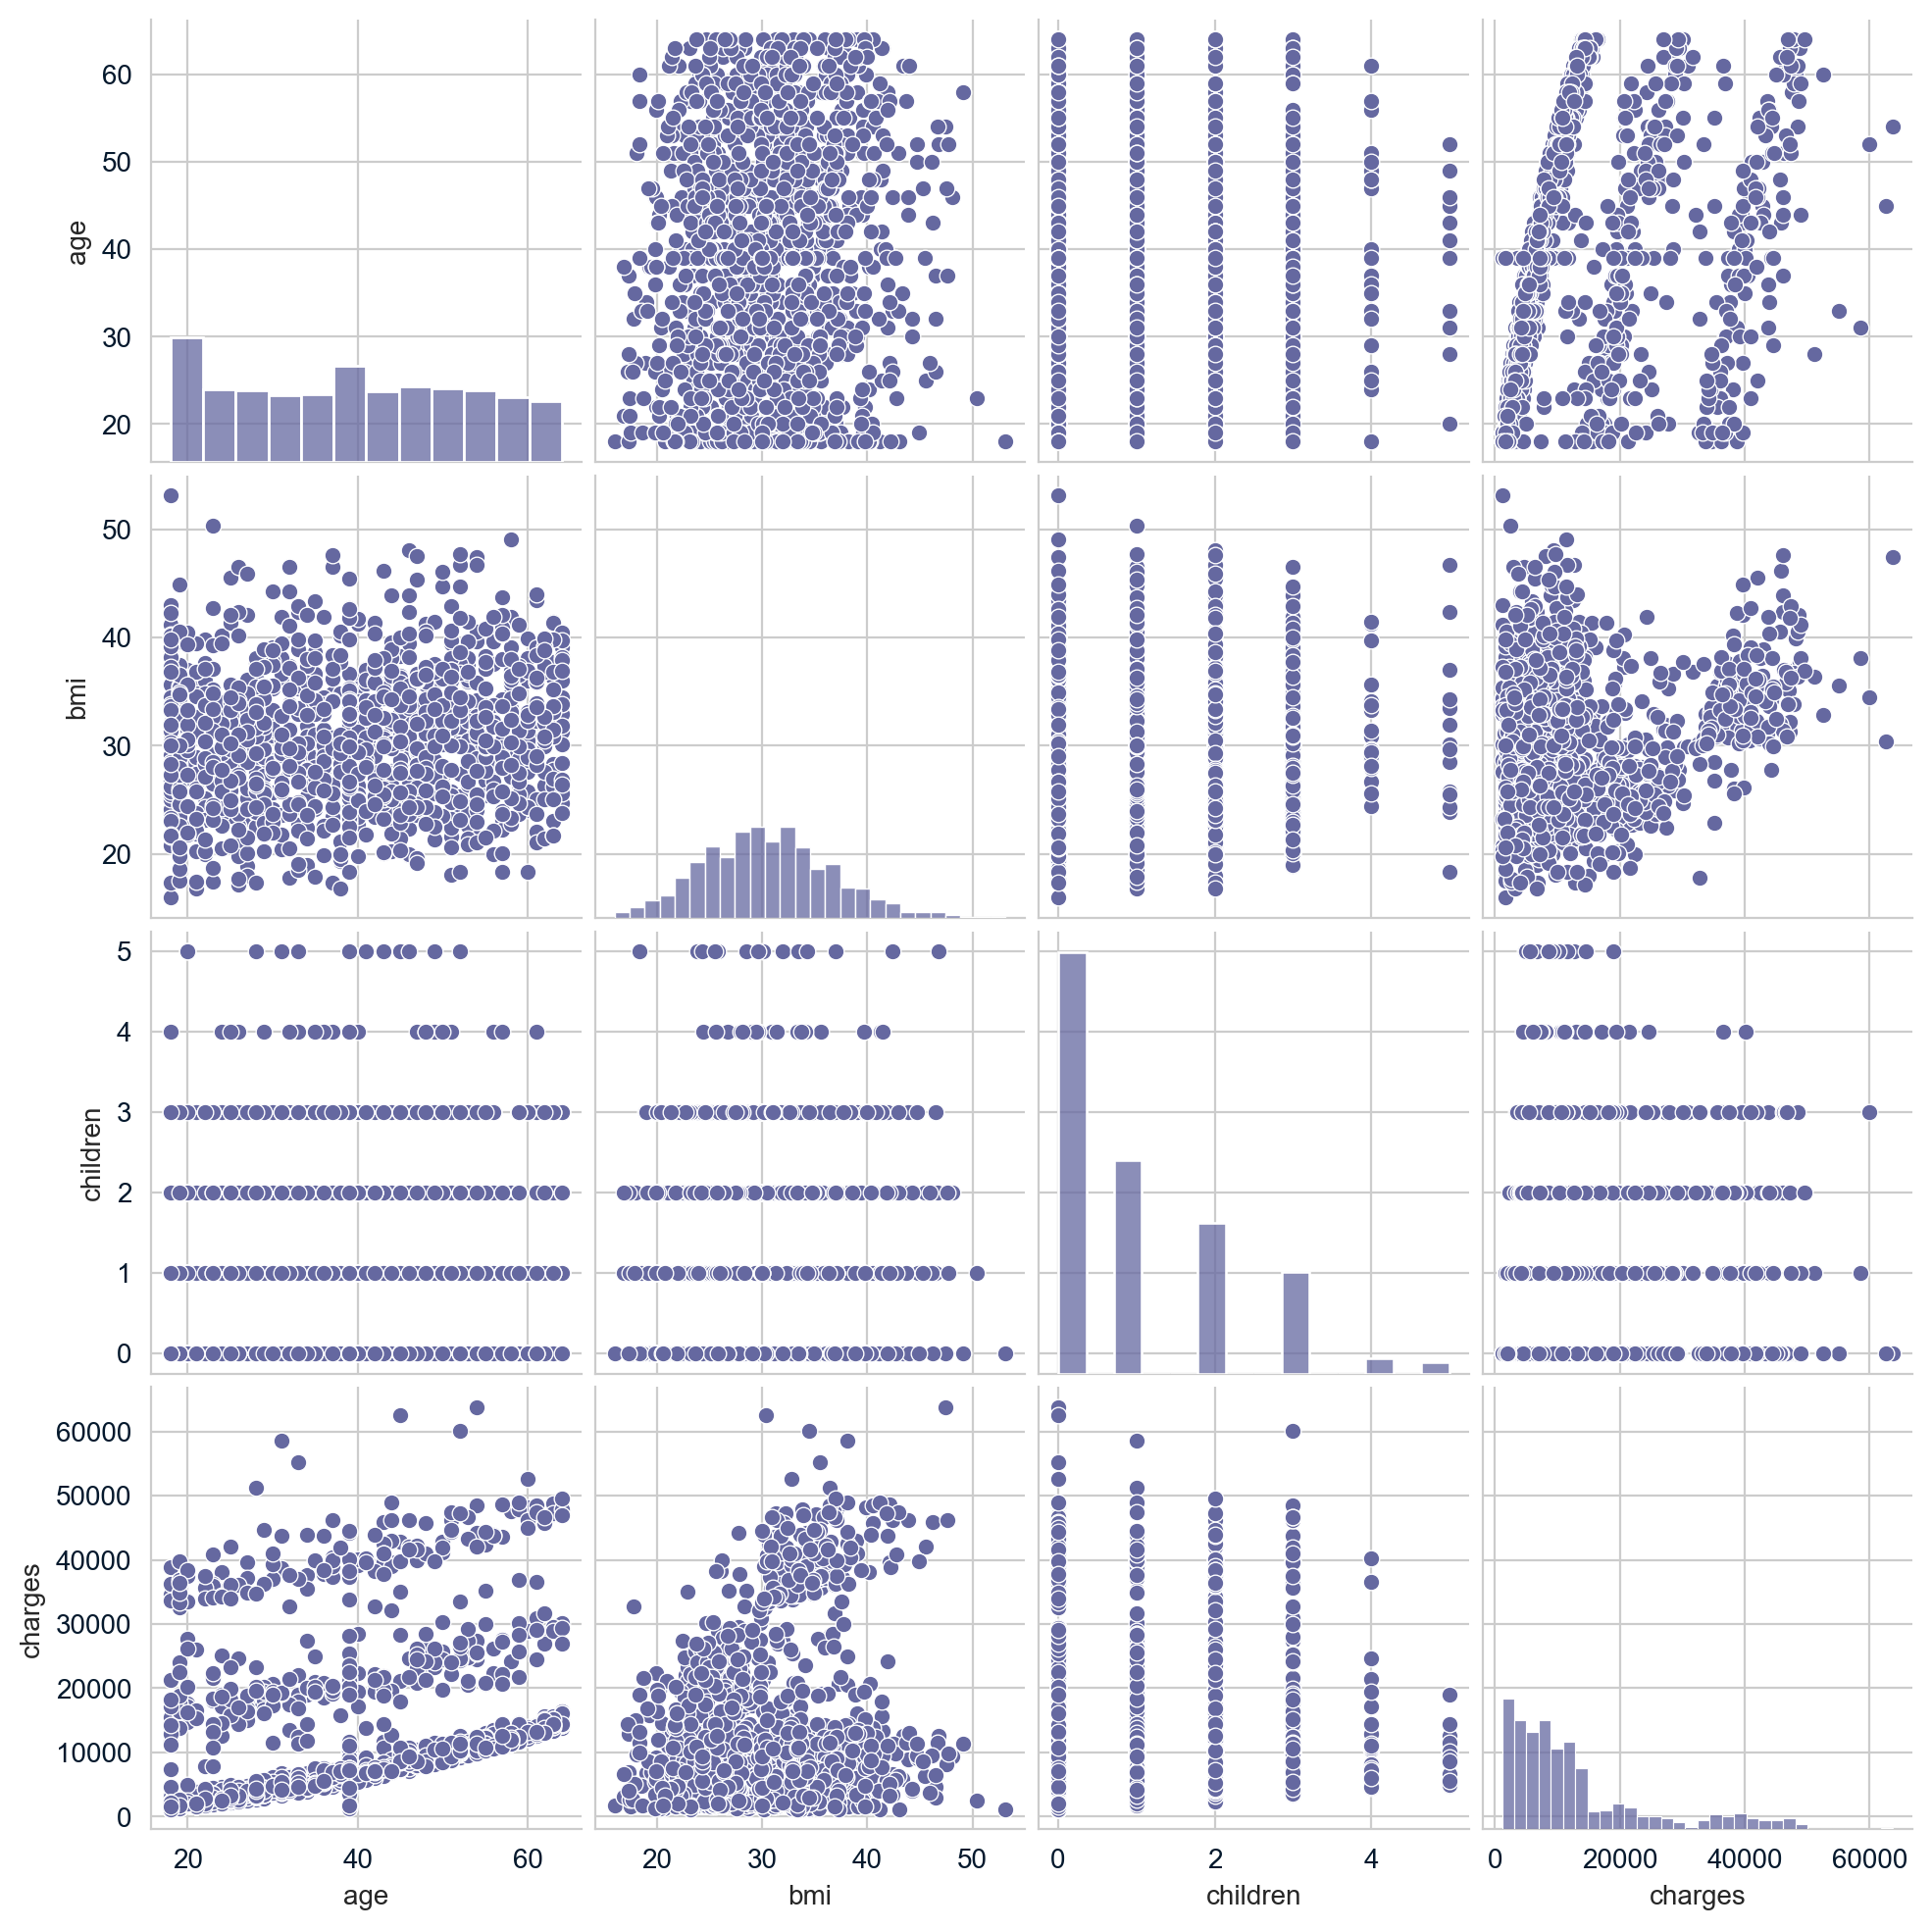

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Pairplot to see relationships between numerical variables
sns.pairplot(insurance_cleaned[['age', 'bmi', 'children', 'charges']])
plt.show()

In [ ]:
# Implement model creation and training here
# Use as many cells as you need

## Model Fitting on Training Dataset

Our approach to model fitting will be as follows:
- we will fit linear regression model and random forest model.
- we will use 10-fold cross-validation and use r-squared score to determine the performance of our model.

Model results:
- The mean-score for regression model is 0.72.
- The mean-score for random forest model is 0.79.
- both model show good score well above the 0.65 threshold. 

## Results for Linear Regression Model

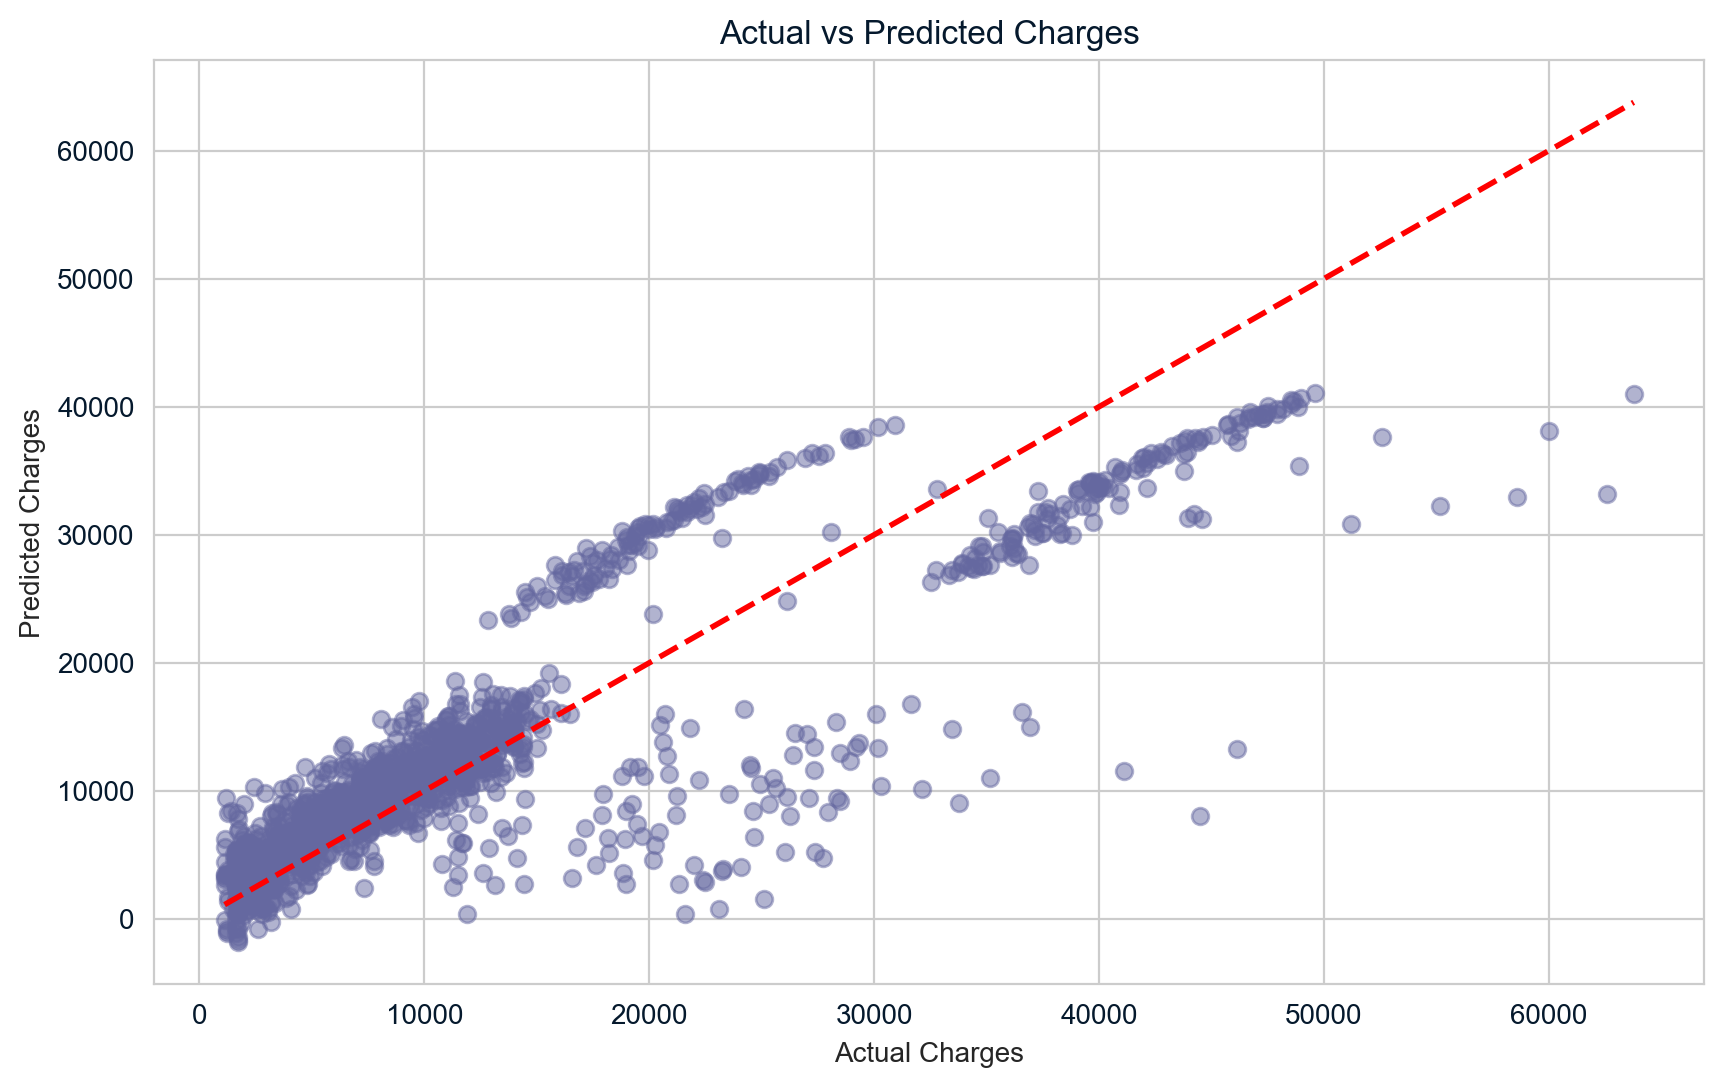

(array([0.71621793, 0.77631477, 0.7008166 , 0.65794208, 0.6989878 ,
        0.6918553 , 0.73338574, 0.75921349, 0.70078009, 0.79628937]),
 0.7231803153049469,
 0.040550816905069655)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Define the features and target variable
X = insurance_cleaned.drop('charges', axis=1)
y = insurance_cleaned['charges']

# Initialize the Linear Regression model
model = LinearRegression()

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_scores = cross_val_score(model, X, y, cv=kf)

# Fit the model on the entire dataset
model.fit(X, y)

# Predict the charges
y_pred = model.predict(X)

# Plot the actual vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()

# calculate the mean and standard deviation of the r-squared for CV
mean_mse = np.mean(cv_scores)
std_mse = np.std(cv_scores)

r2_score = mean_mse

cv_scores, mean_mse, std_mse

## Results for Random Forest Model

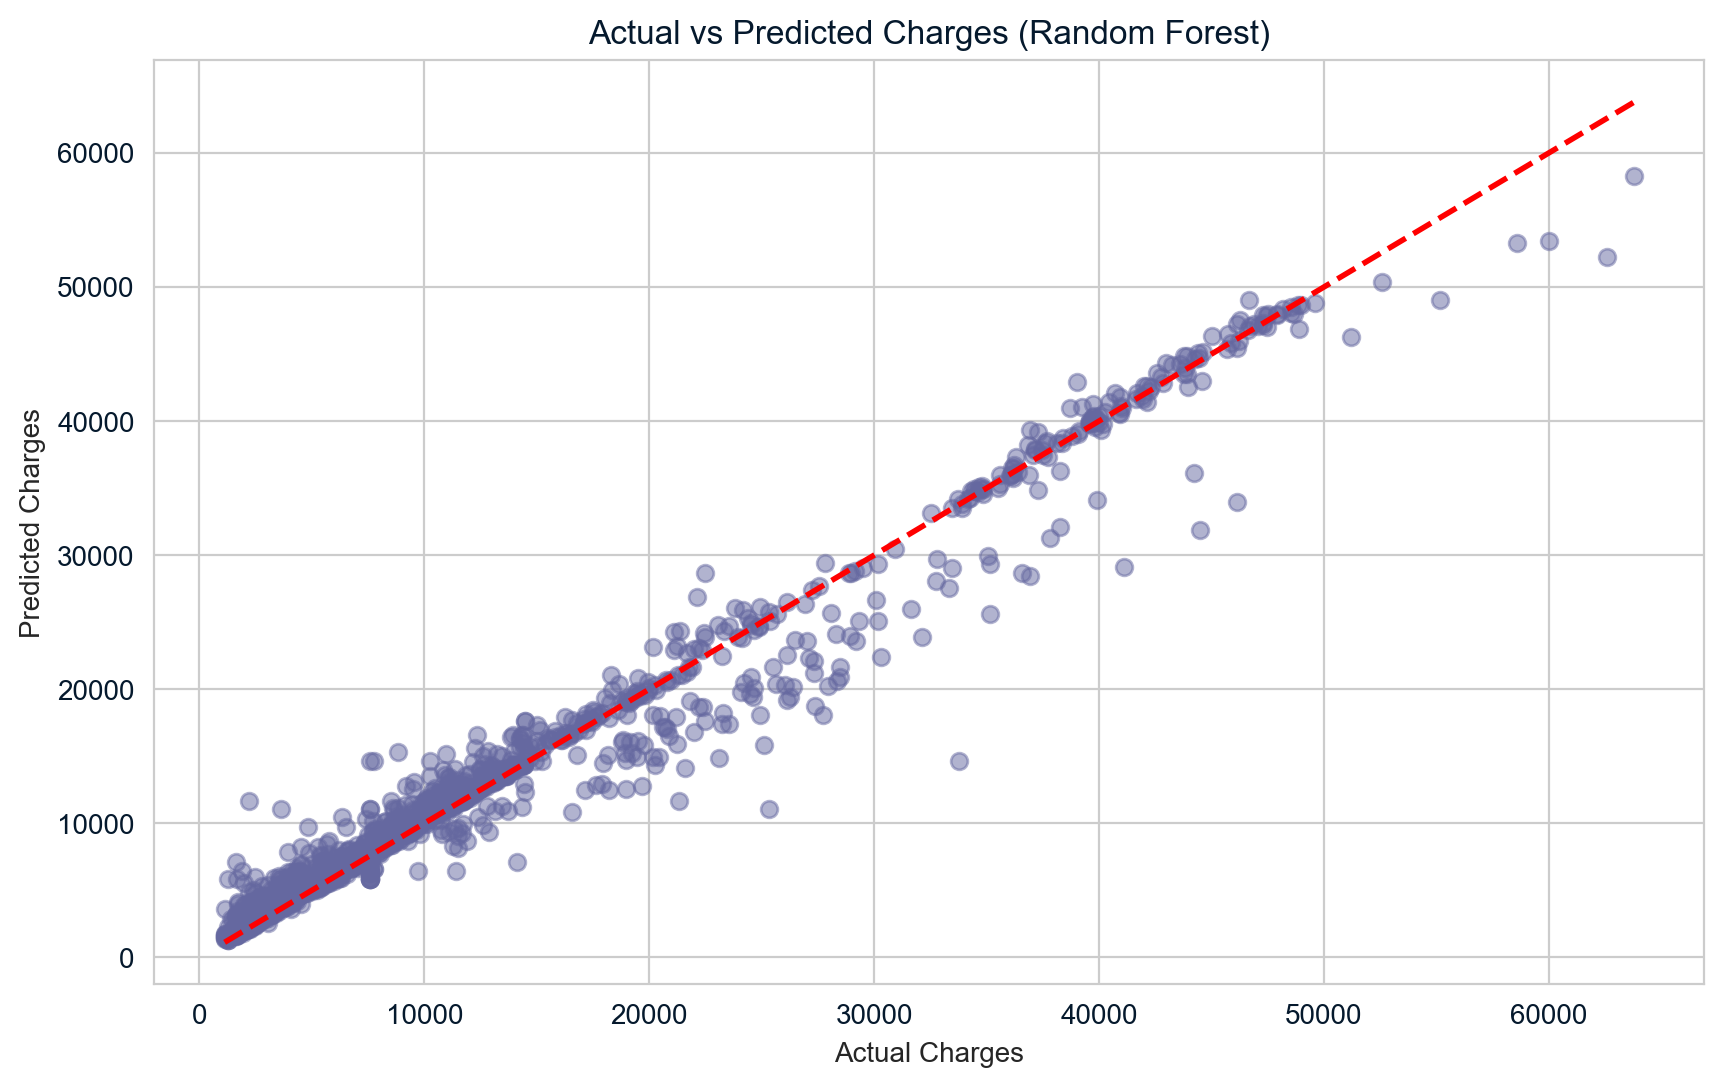

(array([0.81053862, 0.83314693, 0.79888353, 0.74613991, 0.74681925,
        0.74445472, 0.82377059, 0.78628263, 0.81367223, 0.86099625]),
 0.796470465628593,
 0.03815954744063621)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf)

# Fit the model on the entire dataset
rf_model.fit(X, y)

# Predict the charges
y_pred_rf = rf_model.predict(X)

# Plot the actual vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Random Forest)')
plt.show()

# Calculate the mean and standard deviation of the r-squared for CV
mean_mse_rf = np.mean(cv_scores_rf)
std_mse_rf = np.std(cv_scores_rf)
r2_score = mean_mse_rf

cv_scores_rf, mean_mse_rf, std_mse_rf

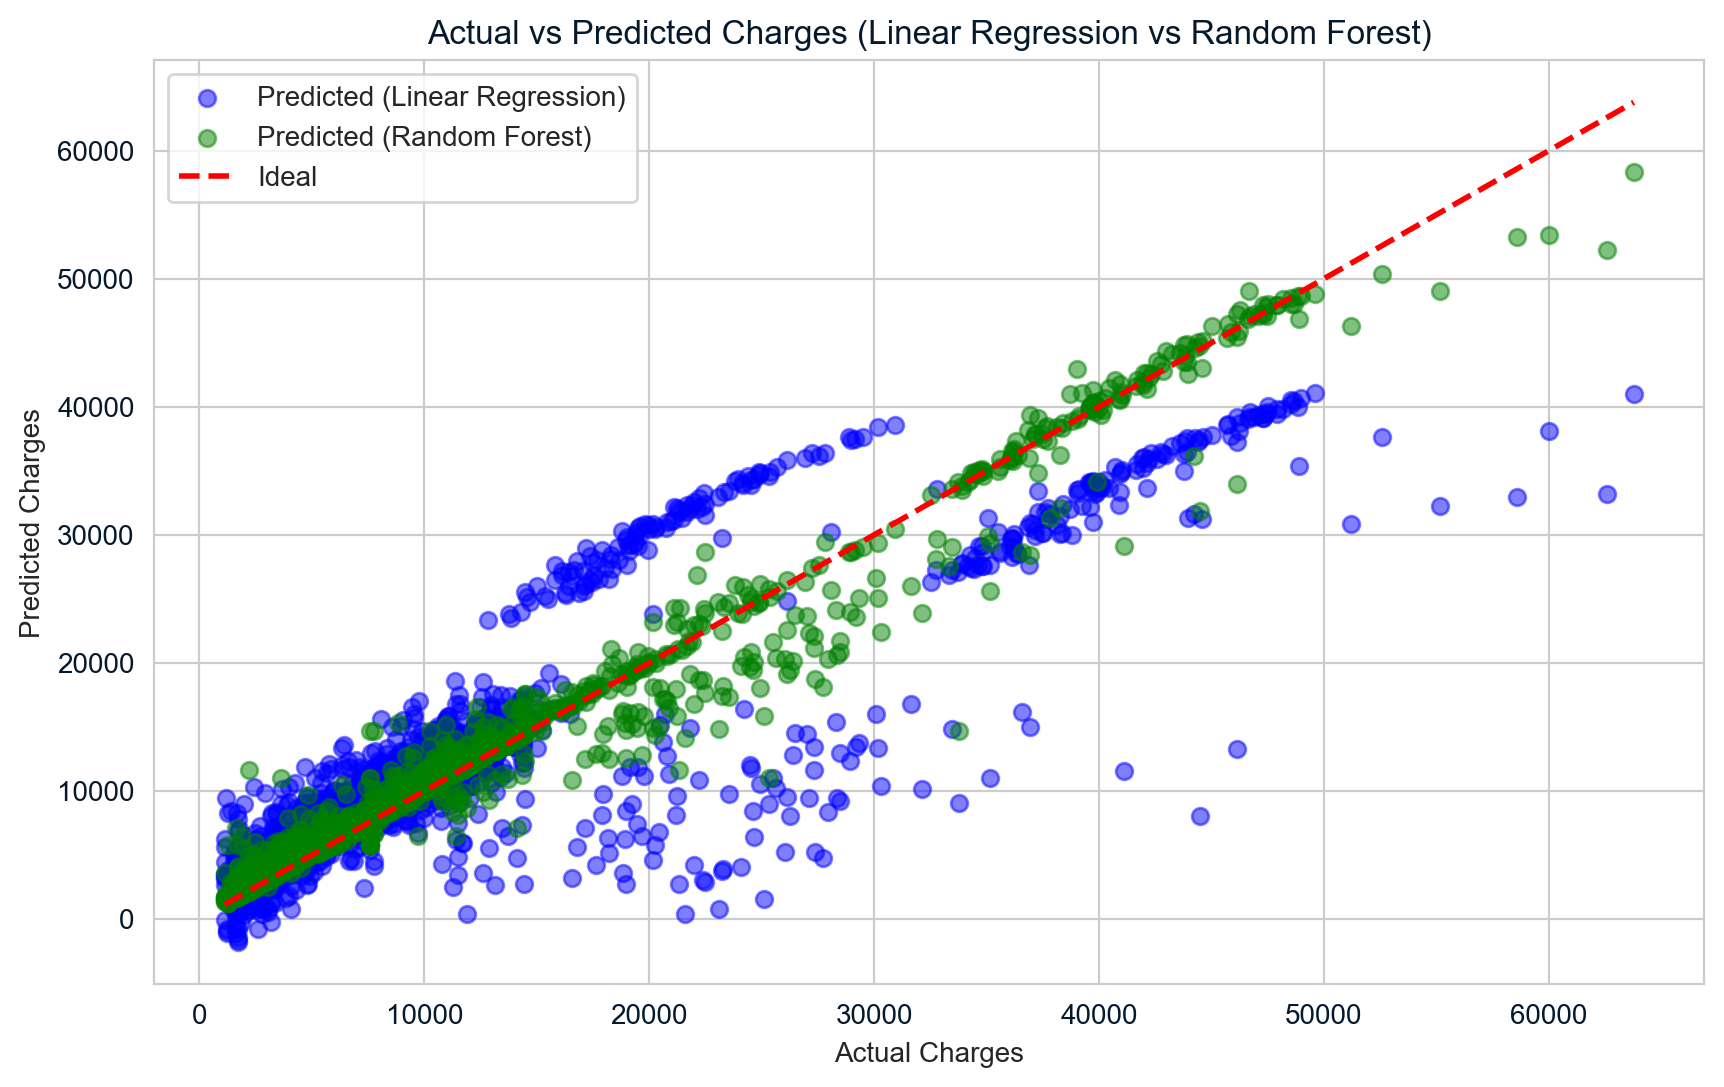

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model on the entire dataset
lr_model.fit(X, y)

# Predict the charges using Linear Regression
y_pred_lr = lr_model.predict(X)

# Plot the actual vs actual (Linear Regression) vs actual (Random Forest) in a single plot
plt.figure(figsize=(10, 6))

# Actual vs Predicted (Linear Regression)
plt.scatter(y, y_pred_lr, alpha=0.5, label='Predicted (Linear Regression)', color='blue')

# Actual vs Predicted (Random Forest)
plt.scatter(y, y_pred_rf, alpha=0.5, label='Predicted (Random Forest)', color='green')

# Ideal line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal')

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Linear Regression vs Random Forest)')
plt.legend()
plt.show()

## Feature-Importance
- Random forest model indicates three features that is important to make prediction on the `charges` - `smoker` status, `bmi` score and `age` (ordered by most significance).

- Linear regression model indicates a single important feature that determine the `charges` - `smoker` status.  


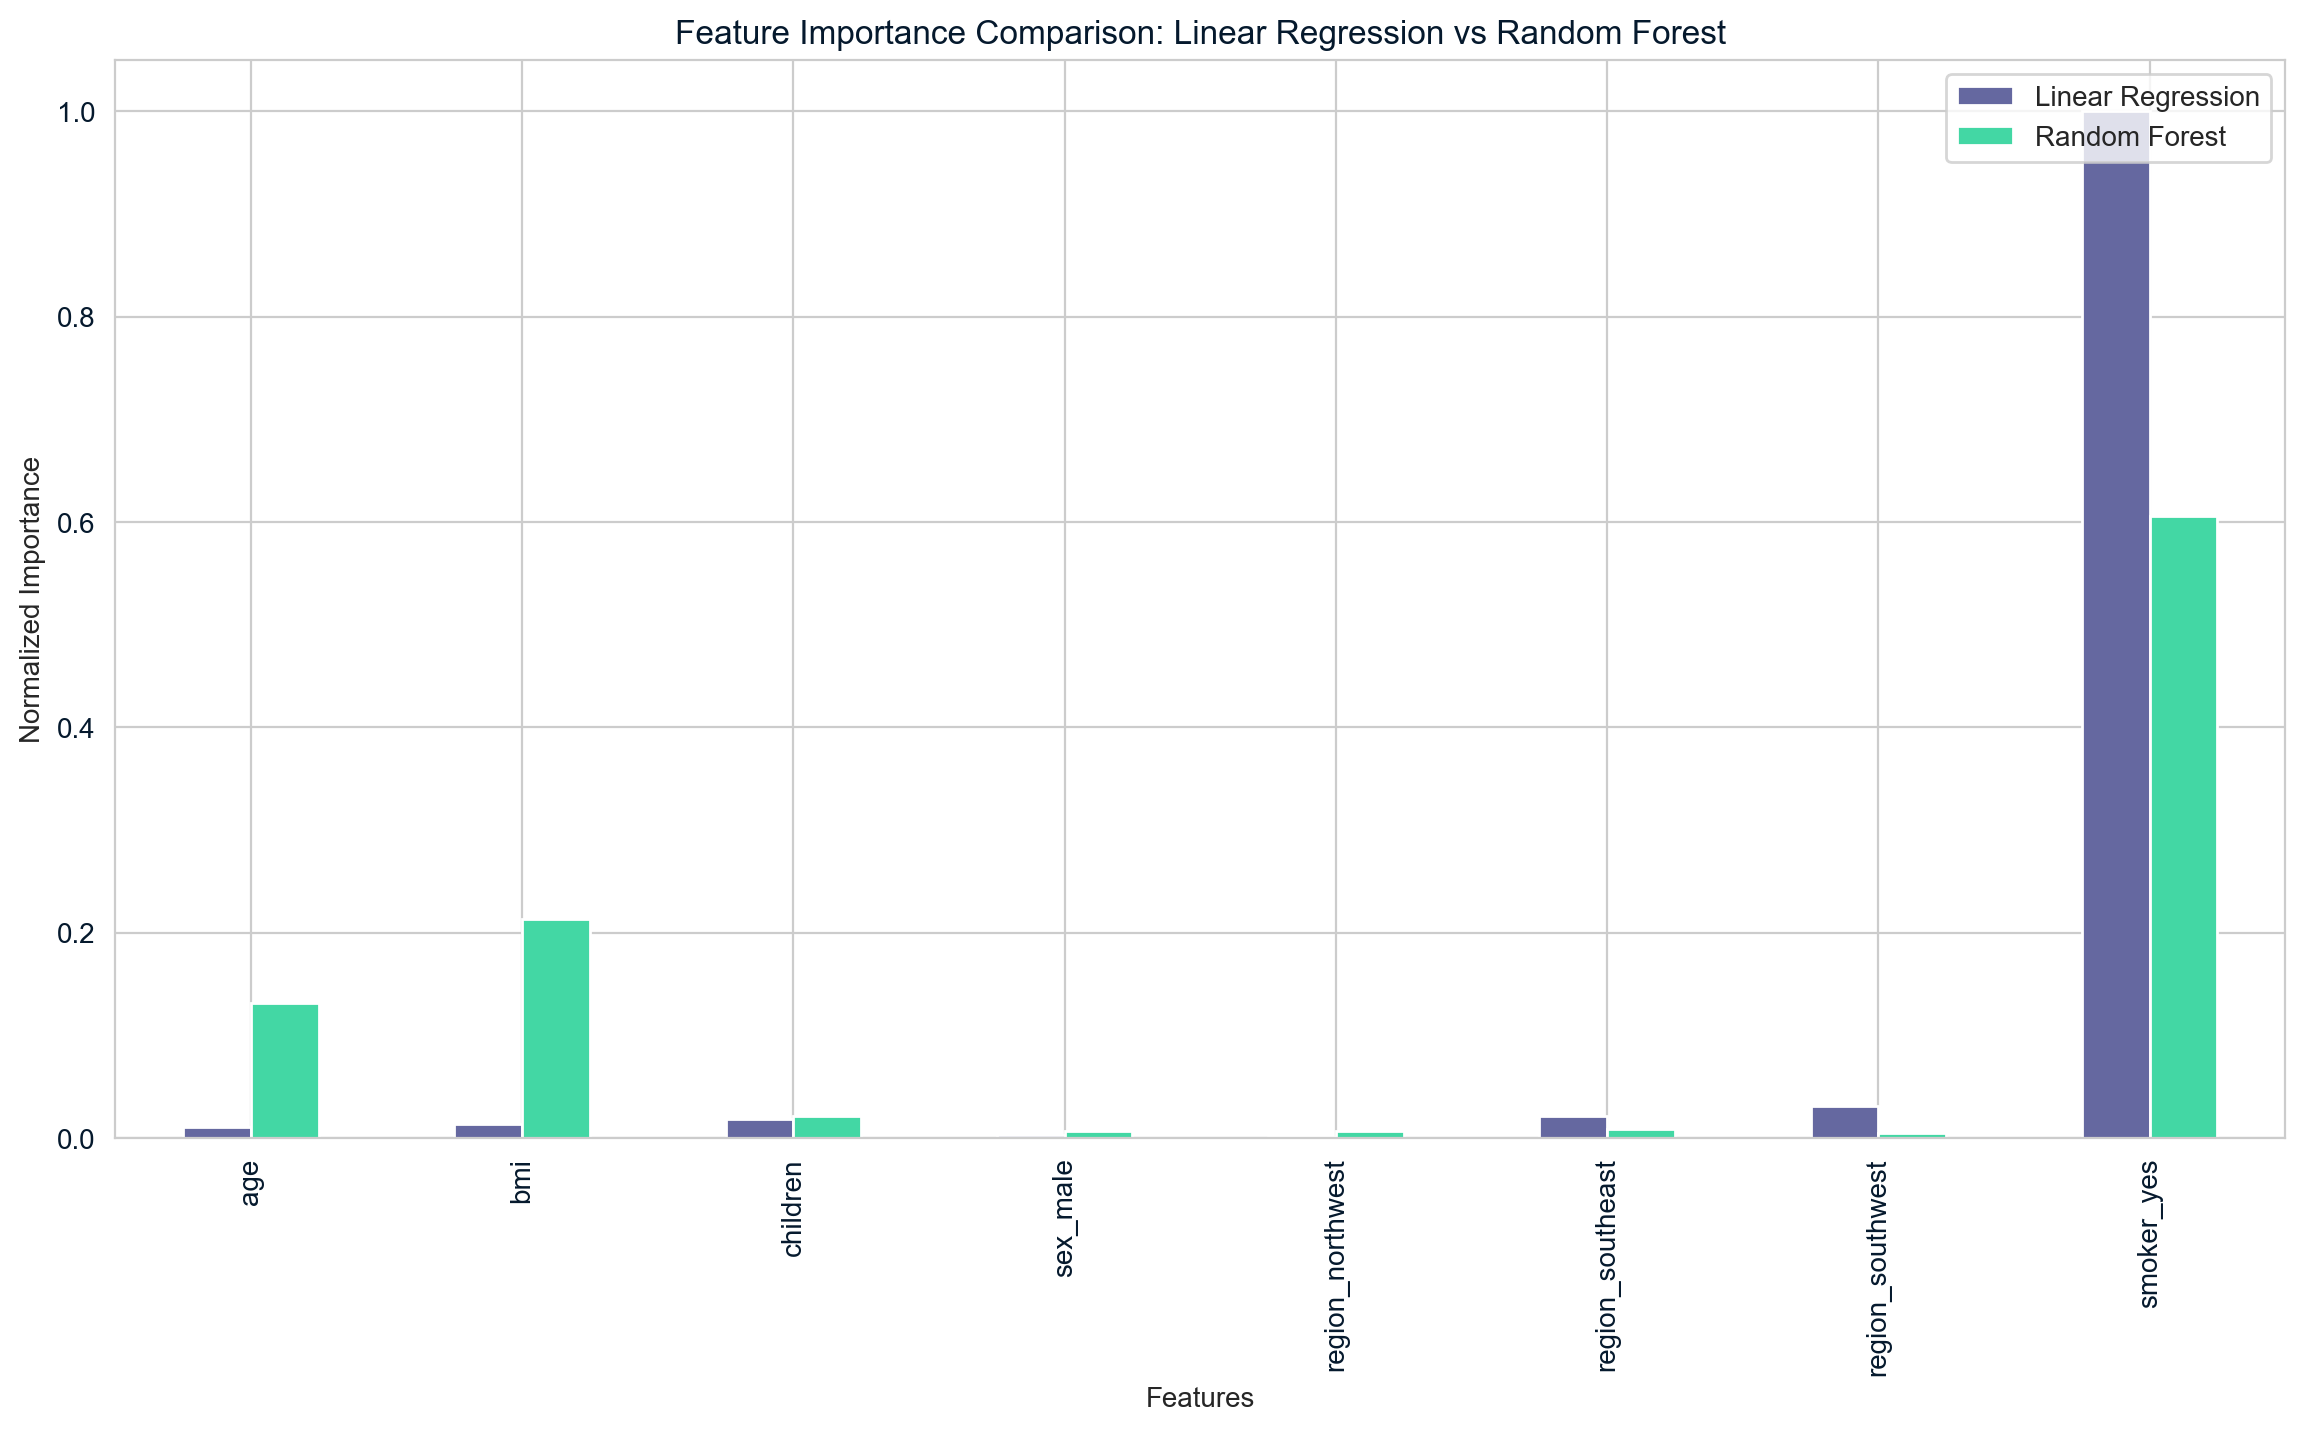

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X, y)

# Train Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Get feature importances for Linear Regression
lr_feature_importance = np.abs(lr_model.coef_)
lr_feature_importance = lr_feature_importance / lr_feature_importance.max()  # Normalize

# Get feature importances for Random Forest
rf_feature_importance = rf_model.feature_importances_

# Create a DataFrame to compare feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Linear Regression': lr_feature_importance,
    'Random Forest': rf_feature_importance
})

# Plot feature importances
feature_importance_df.set_index('Feature').plot(kind='bar', figsize=(14, 7))
plt.title('Feature Importance Comparison: Linear Regression vs Random Forest')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.legend(loc='upper right')
plt.show()

This result seems to confirm with the visualisation of pair-plot obvesrved below:
- `age` and `bmi` score have a linear realtionship with charges
- In general, those who smoke will have tend to have higher charges than those who dosent.

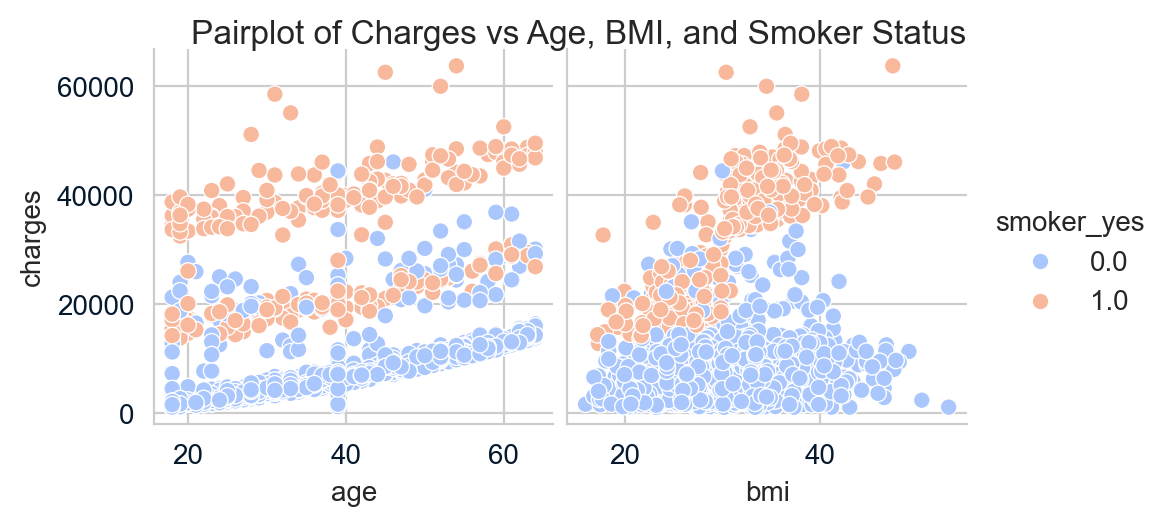

In [ ]:
import seaborn as sns

# Create a pairplot for charges vs age, bmi, and smoker status with charges on the y-axis and smoker as hue
sns.pairplot(insurance_cleaned, y_vars=['charges'], x_vars=['age', 'bmi'], hue='smoker_yes', palette='coolwarm')
plt.suptitle('Pairplot of Charges vs Age, BMI, and Smoker Status', y=1.02)
plt.show()

## Prediction on New Dataset

### Describe and checked for missing values in validation data

From the summary statistics performed on the validation dataset:
- there is no missing values identified.
- the values are consistent (no multiple entry indicating the same value)
- there is no negative value.
- However, we observed some profiles with values that falls outside the maximum range of our training data (eg `children` >5, `age`>64, `bmi`>53). Around 20% of the data is affected by this. Our model might not accurately predict this profile with values outside of the range of our training dataset.


In [ ]:
# Describe the data
display(validation.describe())

# Checking for missing values in the validation dataset
missing_values_validation = validation.isnull().sum()


# # COnfirm unique values
# unique_values_val = {col: validation[col].unique() for col in validation.select_dtypes(include=['object']).columns}
# unique_values_val

unique_values_validation = {col: validation[col].unique() for col in validation.columns}

missing_values_validation, unique_values_validation

,age,bmi,children
count,50.000000,50.000000,50.000000
mean,46.820000,39.539907,2.780000
std,21.681074,17.725844,4.026899
min,18.000000,18.715000,0.000000
25%,28.000000,27.575000,0.000000
50%,44.500000,33.807500,1.000000
75%,60.750000,40.208750,2.750000
max,92.000000,89.097296,13.000000


(age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 dtype: int64,
 {'age': array([18., 39., 27., 71., 28., 70., 29., 42., 48., 63., 51., 60., 57.,
         20., 83., 92., 84., 55., 23., 49., 33., 47., 40., 21., 74., 45.,
         19., 44., 43., 46., 78., 52., 35., 89., 26., 58., 61.]),
  'sex': array(['female', 'male'], dtype=object),
  'bmi': array([24.09      , 26.41      , 29.15      , 65.5021353 , 38.06      ,
         72.95835056, 32.11      , 41.325     , 36.575     , 33.66      ,
         18.905     , 36.67      , 24.53      , 28.7       , 28.975     ,
         30.4       , 89.09729556, 69.12726729, 75.74269295, 26.98      ,
         18.715     , 33.345     , 35.53      , 36.        , 32.3       ,
         35.72      , 65.45474902, 25.8       , 25.74      , 33.7       ,
         32.395     , 33.11      , 20.235     , 26.22      , 24.7       ,
         40.375     , 66.37017332, 38.6       , 21.78      , 60.61753483,
         34.4       , 39.

In [ ]:
# Calculate the percentage of children > 5
children_above_5 = (validation['children'] > 5).sum()
total_count = len(validation)
percentage_children_above_5 = (children_above_5 / total_count) * 100

# Calculate the percentage of age > 64
age_above_64 = (validation['age'] > 64).sum()
percentage_age_above_64 = (age_above_64 / total_count) * 100

# Calculate the percentage of bmi > 53
bmi_above_53 = (validation['bmi'] > 53).sum()
percentage_bmi_above_53 = (bmi_above_53 / total_count) * 100

percentage_children_above_5, percentage_age_above_64, percentage_bmi_above_53

(18.0, 20.0, 20.0)

### Apply Transformation on the Validation Data
We apply the same one-hot encoding transformation to the categorical data.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Perform one-hot encoding on 'sex', 'region', and 'smoker' columns
encoded_features = encoder.fit_transform(validation[['sex', 'region', 'smoker']])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['sex', 'region', 'smoker']))

# Concatenate the original dataframe with the encoded features
validation = pd.concat([validation, encoded_df], axis=1)

# Drop the original 'sex', 'region', and 'smoker' columns
validation.drop(['sex', 'region', 'smoker'], axis=1, inplace=True)

### Prediction on Validation Data

In [ ]:
# Predict the charges
y_pred_val_lr = model.predict(validation)
y_pred_val_rf = rf_model.predict(validation)

# Append the predicted values y_pred_val back to the original validation data
validation['predicted_charges_lr'] = y_pred_val_lr
validation['predicted_charges_rf'] = y_pred_val_rf


validation.head()

,age,bmi,children,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes,predicted_charges_lr,predicted_charges_rf
0,18.0,24.090000,1.0,0.0,0.0,1.0,0.0,0.0,744.481292,3427.510445
1,39.0,26.410000,0.0,1.0,0.0,0.0,0.0,1.0,30853.785076,22028.255746
2,27.0,29.150000,0.0,1.0,0.0,1.0,0.0,1.0,28083.172156,19209.702704
3,71.0,65.502135,13.0,1.0,0.0,1.0,0.0,1.0,56701.668947,58750.224532
4,28.0,38.060000,0.0,1.0,0.0,1.0,0.0,0.0,7258.964874,3167.259086


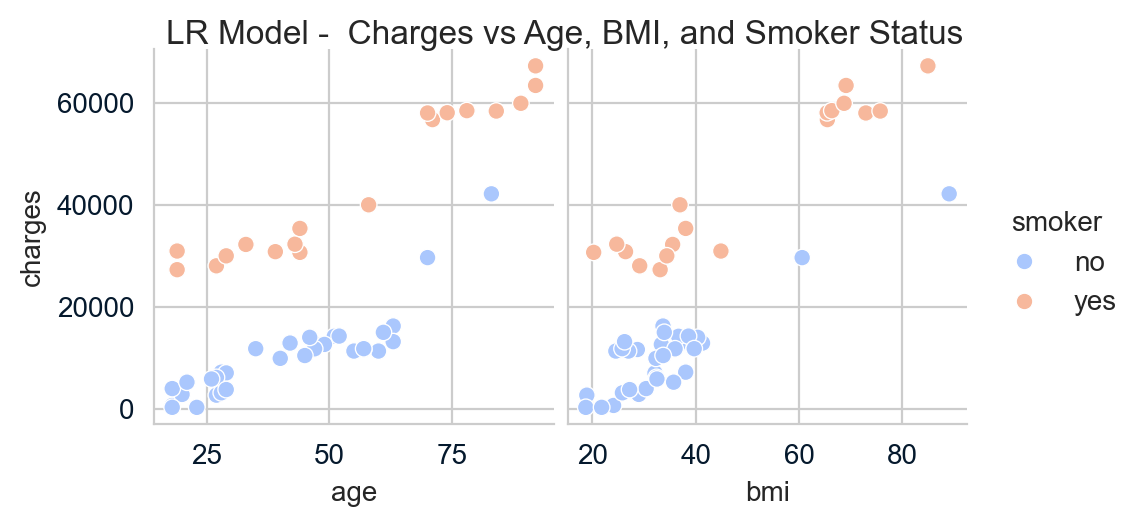

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for pairplot
pairplot_df = validation[['age', 'bmi', 'smoker_yes', 'predicted_charges_lr']].copy()
pairplot_df.rename(columns={'predicted_charges_lr': 'charges', 'smoker_yes': 'smoker'}, inplace=True)

# Convert smoker column back to categorical for better visualization
pairplot_df['smoker'] = pairplot_df['smoker'].map({1: 'yes', 0: 'no'})
# Create pairplot
sns.pairplot(pairplot_df, y_vars='charges', x_vars=['age', 'bmi'], hue='smoker', palette='coolwarm')
plt.suptitle('LR Model -  Charges vs Age, BMI, and Smoker Status', y=1.02)
plt.show()

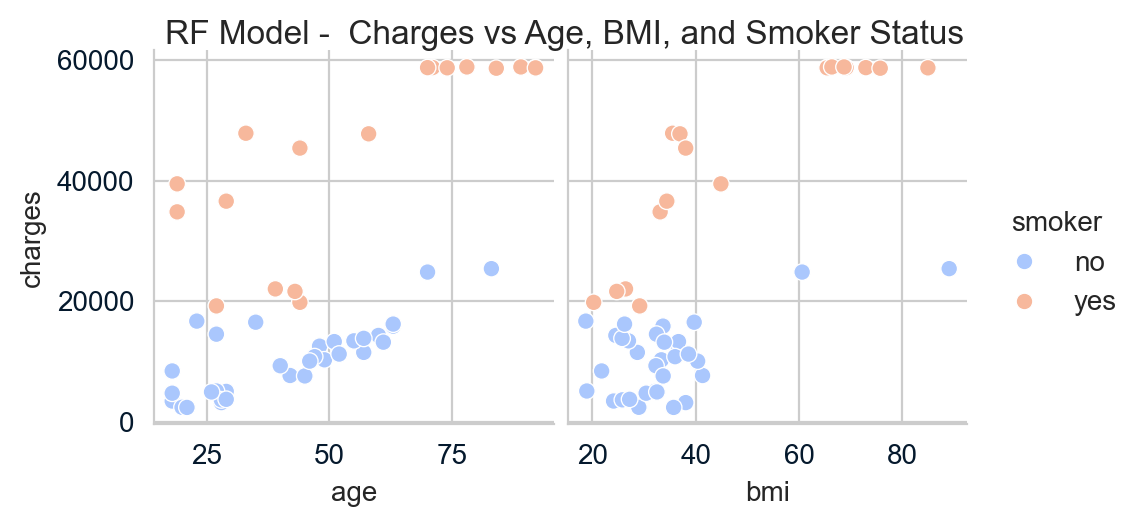

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for pairplot
pairplot_df = validation[['age', 'bmi', 'smoker_yes', 'predicted_charges_rf']].copy()
pairplot_df.rename(columns={'predicted_charges_rf': 'charges', 'smoker_yes': 'smoker'}, inplace=True)

# Convert smoker column back to categorical for better visualization
pairplot_df['smoker'] = pairplot_df['smoker'].map({1: 'yes', 0: 'no'})
# Create pairplot
sns.pairplot(pairplot_df, y_vars='charges', x_vars=['age', 'bmi'], hue='smoker', palette='coolwarm')
plt.suptitle('RF Model -  Charges vs Age, BMI, and Smoker Status', y=1.02)
plt.show()

In [ ]:
validation_data = validation.copy()
validation_data.rename(columns={'predicted_charges_lr': 'predicted_charges'}, inplace=True)
validation_data['predicted_charges'] = validation_data['predicted_charges'].apply(lambda x: x if x >= 1000 else 1000)